<a href="https://colab.research.google.com/github/spentaur/DS-Unit-2-Applied-Modeling/blob/master/Sprint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍔

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [1]:
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

     |████████████████████████████████| 102kB 2.7MB/s 
     |████████████████████████████████| 112kB 2.7MB/s 
     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 614kB 40.6MB/s 
     |████████████████████████████████| 235kB 42.0MB/s 
     |████████████████████████████████| 307kB 38.0MB/s 
     |████████████████████████████████| 215kB 39.0MB/s 
     |████████████████████████████████| 51kB 20.7MB/s 
     |████████████████████████████████| 51kB 19.2MB/s 
     |████████████████████████████████| 737kB 34.9MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145035 sha256=5954457cd0714198baf293a7841ae276b0b3bba2e6f488667f7942afd9033102
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=301475b4ed92e77e57b00b6a759917a901c3bc76ce821414409286ff4683eee0
  Stored 

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import eli5
from eli5.sklearn import PermutationImportance
import shap

Using TensorFlow backend.


#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [0]:
target = 'Fail'

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make all four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [5]:
train.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')

In [6]:
# drop useless columns
train.nunique().sort_values()

State                  1
Fail                   2
Risk                   3
City                  39
Inspection Type       51
Zip                   86
Facility Type        329
Inspection Date     2257
Location           13410
Latitude           13410
Longitude          13410
Address            13954
AKA Name           16350
DBA Name           17049
License #          21421
Violations         42164
Inspection ID      51916
dtype: int64

In [0]:
drop = ['State', 'AKA Name', 'License #', 'Inspection ID', 'Address']
train.drop(drop, axis=1, inplace=True)
test.drop(drop, axis=1, inplace=True)

In [8]:
train.dtypes.sort_values()

Fail                 int64
Zip                float64
Latitude           float64
Longitude          float64
DBA Name            object
Facility Type       object
Risk                object
City                object
Inspection Date     object
Inspection Type     object
Violations          object
Location            object
dtype: object

In [9]:
train.isna().sum() / len(train) * 100

DBA Name            0.000000
Facility Type       0.431466
Risk                0.023114
City                0.102088
Zip                 0.050081
Inspection Date     0.000000
Inspection Type     0.001926
Violations         18.597350
Latitude            0.381385
Longitude           0.381385
Location            0.381385
Fail                0.000000
dtype: float64

In [0]:
train['Violations'] = train['Violations'].fillna('')
test['Violations'] = test['Violations'].fillna('')

In [0]:
# Violations: An establishment can receive one or more of 45 distinct violations
# (violation numbers 1-44 and 70). For each violation number listed for a given 
# establishment, the requirement the establishment must meet in order for it to
# NOT receive a violation is noted, followed by a specific description of the 
# findings that caused the violation to be issued. 

def violations(data):
    data = data.copy()
    data['Number of Criticals'] = data['Violations'].str.count('CRITICAL VIOLATION|SERIOUS VIOLATION').fillna(0.0)
    data['Number of Violations'] = data['Violations'].str.split('|').str.len()
    
    return data

In [0]:
train = violations(train)
test = violations(test)

In [13]:
print('fail')
print(train[train['Fail'] == 1][['Number of Criticals', 'Number of Violations']].max())
print('\n')
train[train['Fail'] == 0][['Number of Criticals', 'Number of Violations']].max()

fail
Number of Criticals     11
Number of Violations    28
dtype: int64




Number of Criticals      2
Number of Violations    18
dtype: int64

In [0]:
X_train = train[['Number of Criticals', 'Number of Violations', 'Inspection Type']]
X_test = test[['Number of Criticals', 'Number of Violations', 'Inspection Type']]
y_train = train[target]
y_test = test[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train);

In [15]:
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_proba)

0.9087604958138656

In [16]:
train = train.drop(['Violations', 'Number of Criticals', 'Number of Violations'], axis=1)
test = test.drop(['Violations', 'Number of Criticals', 'Number of Violations'], axis=1)
train.columns

Index(['DBA Name', 'Facility Type', 'Risk', 'City', 'Zip', 'Inspection Date',
       'Inspection Type', 'Latitude', 'Longitude', 'Location', 'Fail'],
      dtype='object')

**Can't quite get to the > .9 but I believe that the Violations column shouldn't be used becuase it's not information I'd have prior to the inspection. I'm sure if I engineered the feature more I could get the score much higher. I'd also maybe need to look more into whether including Inspection Type is safe.**

In [0]:
features = ['DBA Name',
            'Facility Type',
            'Risk',
            'City',
            'Zip',
            'Inspection Date',
            'Inspection Type',
            'Latitude',
            'Longitude',
            'Location']

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [18]:
X = train[features]
y = train[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2)
X_train.shape, X_val.shape

((41532, 10), (10384, 10))

In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train);

In [20]:
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_pred_proba)
roc_auc_val

0.6724031287500231

In [21]:
pipeline.score(X_val, y_val)

0.7281394453004623

In [22]:
y_pred_proba = pipeline.predict_proba(test[features])[:, 1]
roc_auc_test = roc_auc_score(test[target], y_pred_proba)
roc_auc_test

0.6723952595603613

## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [23]:
# permutaion importance

transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_transformed, y_train)

permuter = PermutationImportance(
    clf, 
    scoring='roc_auc',
    n_iter=2,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Weight,Feature
0.1250 ± 0.0000,Inspection Type
0.0116 ± 0.0089,Inspection Date
0.0116 ± 0.0025,Latitude
0.0033 ± 0.0020,Longitude
0.0023 ± 0.0014,Facility Type
0.0017 ± 0.0010,Zip
0.0008 ± 0.0041,DBA Name
0.0003 ± 0.0052,Risk
0.0001 ± 0.0002,City
-0.0074 ± 0.0004,Location


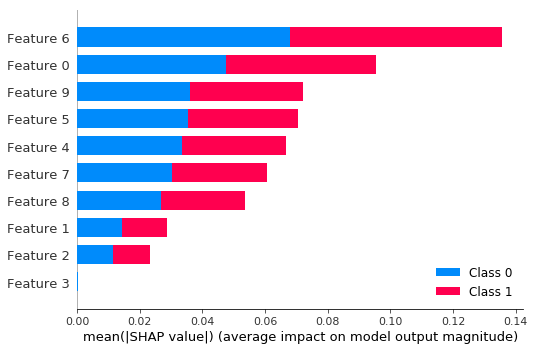

In [25]:
# Shapley Values

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train_transformed[:100])

shap.summary_plot(shap_values, X_train_transformed[:100], plot_type="bar")